In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/Colab Notebooks/TransformerECA

/content/drive/MyDrive/Colab Notebooks/TransformerECA


In [ ]:
from datasets import load_dataset

dataset_name = "1dCA_r2s20T20" #"1dCA_r2s20T20" # "1dCA_r3s24T20" # "1dCA_r2s84T6"
CA_data = load_dataset("mbur/"+dataset_name)['train']

Repo card metadata block was not found. Setting CardData to empty.
/usr/local/bin/miniconda/envs/py310/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
print(CA_data[42])

{'rule': '11001110000111101100000100010000', 't=0': '01001111000001100100', 't=1': '01000000011101100101', 't=2': '00011111001010100100', 't=3': '11000000001000000101', 't=4': '10011111101011110111', 't=5': '00000000000110001100', 't=6': '11111111110110101101', 't=7': '00000000001010010111', 't=8': '01111111101000011110', 't=9': '00000000000011000000', 't=10': '11111111111011011111', 't=11': '00000000000101110000', 't=12': '11111111110111100111', 't=13': '00000000001100000000', 't=14': '11111111101101111111', 't=15': '00000000010111000000', 't=16': '11111111011110011111', 't=17': '00000000110000000000', 't=18': '11111110110111111111', 't=19': '00000001011100000000'}


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_ca_orbits(dataset, start_index, k):
    # Define the colormap: yellow for 1, blue for 0
    cmap = plt.cm.colors.ListedColormap(['blue', 'yellow'])
    bounds = [0, 0.5, 1]
    norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)

    # Set up the plot with KxK subplots
    fig, axes = plt.subplots(k, k, figsize=(16, 16))

    # Flatten the axes array for easy indexing
    axes = axes.flatten()

    # Process K*K samples starting from index 'start_index'
    for i in range(k*k):
        # Get the current sample
        sample = dataset[start_index + i]

        # Extract CA states and convert them to numerical arrays
        ca_states = [np.array([int(bit) for bit in sample[f't={t}']]) for t in range(len(sample) - 1)]

        # Plot each CA orbit as a stack of horizontal stripes
        axes[i].imshow(ca_states, cmap=cmap, norm=norm)#(ca_states, aspect='auto', cmap=cmap, norm=norm)
        axes[i].set_title(f"Sample {start_index + i}")
        axes[i].axis('off')

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.savefig('fig_ca.pdf', format='pdf')
    plt.show()

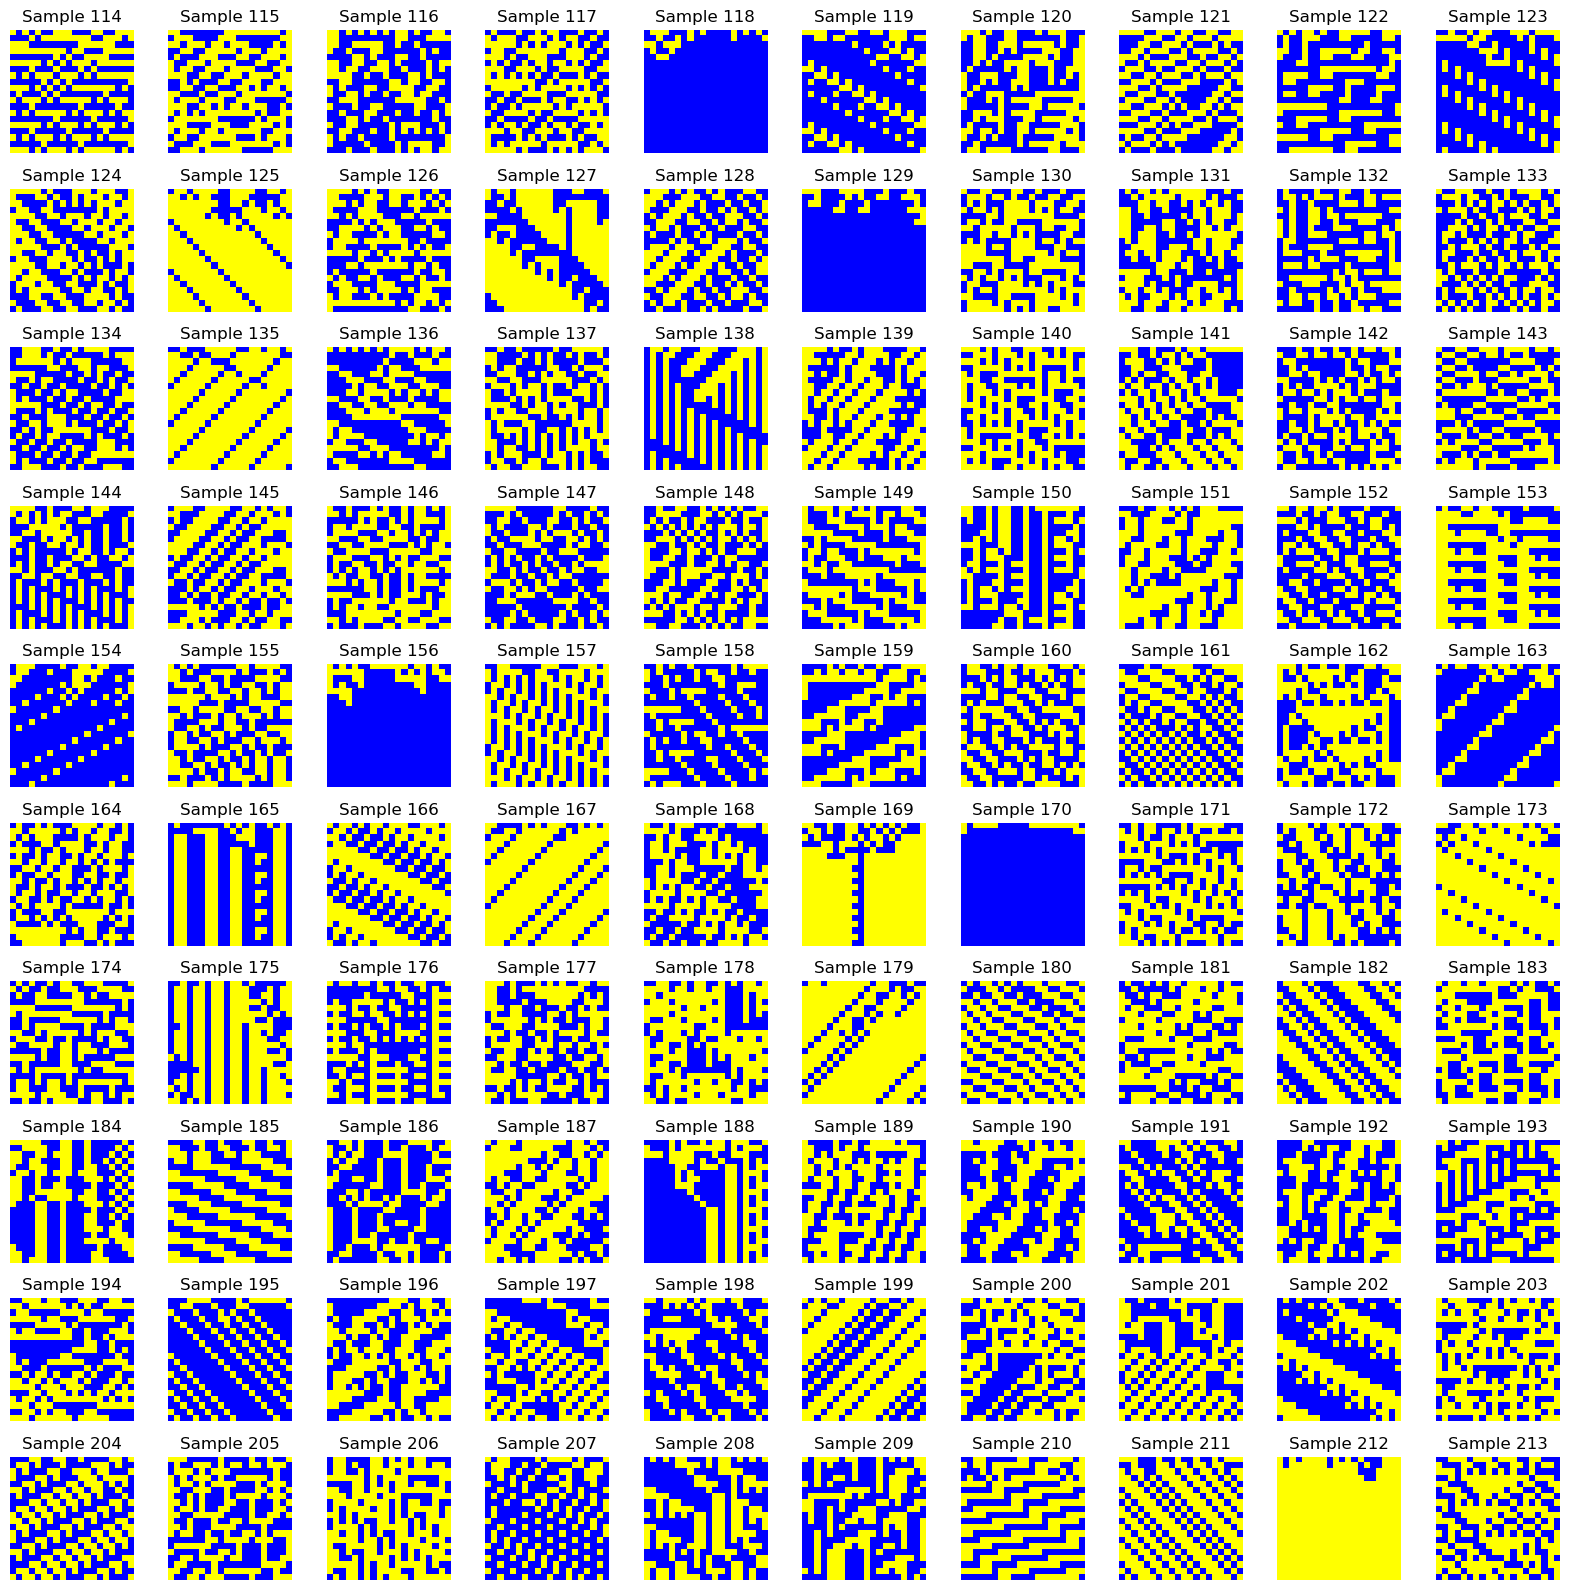

In [ ]:
# Call the visualization function
start_ind = 114
size = 10 # visualize 'size' by 'size' samples
visualize_ca_orbits(CA_data, start_ind, size)

In [ ]:
import pyeda.inter as py

def rebuild_circuit_reversed_bits(rule_bin, r):
    """
    Rebuild a Boolean circuit from the truth table where the input bit order is reversed.

    Parameters:
    rule_bin (str): Binary string representing the truth table.
    r (int): The radius of the CA.

    Returns:
    circuit: A Boolean expression representing the circuit with reversed bit order.
    """
    num_vars = 2 * r + 1
    variables = [py.exprvar(f'x{i}') for i in range(num_vars)]

    # List to hold minterms
    minterms = []

    # Iterate through the truth table and build minterms for each entry where the output is 1
    for i in range(2 ** num_vars):
        if rule_bin[i] == '1':
            # Create a minterm (AND gate of variables and their negations) with reversed bit order
            term = []
            for j in range(num_vars):
                # Reverse the order by accessing variables in reverse
                if (i >> j) & 1:
                    term.append(variables[num_vars - 1 - j])  # Access in reversed order
                else:
                    term.append(~variables[num_vars - 1 - j])  # Access in reversed order
            minterms.append(py.And(*term))

    # Combine all minterms with OR to build the full circuit
    if minterms:
        circuit = py.Or(*minterms)
    else:
        circuit = py.Zero  # Default to always 0 if no minterms exist

    # Simplify the Boolean circuit using the Espresso algorithm
    simplified_circuit, = py.espresso_exprs(circuit.to_dnf())

    return simplified_circuit


def print_truth_tables_reversed_bits(rule_bin, circuit, r):
    """
    Print the initial truth table and the truth table generated from the circuit with reversed bit order side by side.

    Parameters:
    rule_bin (str): Binary string representing the truth table.
    circuit: The Boolean circuit generated from the rule_bin with reversed bit order.
    r (int): The radius of the CA.
    """
    num_vars = 2 * r + 1
    variables = [py.exprvar(f'x{i}') for i in range(num_vars)]
    truth_table_len = 2 ** num_vars

    print(f"{'Input':<20} | {'Initial Truth Table':<20} | {'Generated Truth Table':<20}")
    print("-" * 60)

    for i in range(truth_table_len):
        # Generate the input combination
        input_combination = [(i >> j) & 1 for j in range(num_vars)]
        # No reverse() needed because the bit order is reversed in the circuit generation itself

        # Convert input combination to a dictionary for circuit evaluation
        substitution = {variables[num_vars - 1 - j]: input_combination[j] for j in range(num_vars)}

        # Evaluate the circuit with the current input combination
        eval_expr = circuit.restrict(substitution)

        # Convert evaluation result to 1 or 0
        if eval_expr.is_one():
            generated_output = 1
        elif eval_expr.is_zero():
            generated_output = 0
        else:
            generated_output = "Error"

        # Get the initial truth table output from rule_bin
        initial_output = int(rule_bin[i])

        # Print input combination, initial truth table output, and generated circuit output
        input_str = " ".join(map(str, input_combination))
        print(f"{input_str:<20} | {initial_output:<20} | {generated_output:<20}")


In [ ]:
import numpy as np
import pyeda.inter as py

def generate_ca_orbit_with_circuit(initial_state, circuit, T, r=1):
    """
    Generate the CA orbit using the Boolean circuit for T time steps.

    Parameters:
    initial_state (list): The initial state of the CA.
    circuit (expr): The Boolean circuit representing the CA rule.
    T (int): The number of time steps to generate.
    r (int): The radius of the CA.

    Returns:
    orbit (list): The generated orbit (list of states).
    """
    size = len(initial_state)
    orbit = [initial_state]

    for t in range(1, T):
        next_state = []
        for i in range(size):
            # Create the input window of size 2r + 1 (r cells to the left, center, r cells to the right)
            window = []
            for j in range(-r, r + 1):
                window_index = (i + j) % size  # Circular boundary: Wrap around
                window.append(orbit[-1][window_index])

            # Construct the substitution dictionary in natural order
            substitution = {py.exprvar(f'x{k}'): window[k] for k in range(len(window))}

            # Evaluate the circuit with the current values of the input window
            eval_expr = circuit.restrict(substitution)

            # Convert to 1 or 0 based on evaluation
            if eval_expr.is_one():
                next_state.append(1)
            elif eval_expr.is_zero():
                next_state.append(0)
            else:
                raise ValueError(f"Unexpected result during evaluation: {eval_expr}")

        orbit.append(next_state)

    return orbit


def compare_orbit_with_dataset(dataset, sample_index, circuit, T, r=1):
    """
    Compare the CA orbit generated by the circuit with the dataset.

    Parameters:
    dataset: The dataset containing the CA states.
    sample_index (int): The index of the sample to compare.
    circuit: The Boolean circuit generated from the rule.
    T (int): The number of time steps to compare.
    r (int): The radius of the CA.

    Returns:
    is_matching (bool): Whether the generated CA states match the dataset.
    """
    # Extract the sample from the dataset
    sample = dataset[sample_index]

    # Get the initial state from the dataset
    initial_state = [int(bit) for bit in sample['t=0']]

    # Generate the CA orbit using the circuit
    generated_orbit = generate_ca_orbit_with_circuit(initial_state, circuit, T, r)

    # Compare each state from the dataset with the generated orbit
    for t in range(T):
        dataset_state = [int(bit) for bit in sample[f't={t}']]
        generated_state = generated_orbit[t]

        if dataset_state != generated_state:
            print(f"Mismatch at time step {t}:")
            print(f"Dataset state:   {dataset_state}")
            print(f"Generated state: {generated_state}")
            return False

    return True


# Example usage
T = 20  # Number of time steps to compare
sample_index = 253  # Example sample index from the dataset
r = 2  # Example radius

# Extract the rule (truth table) from the dataset
sample = CA_data[sample_index]
rule_bin = sample['rule']

# Rebuild the Boolean circuit from the truth table with reversed bit order
circuit = rebuild_circuit_reversed_bits(rule_bin, r)


# Verify that the generated CA states match the dataset
is_matching = compare_orbit_with_dataset(CA_data, sample_index, circuit, T, r)

if is_matching:
    print("The generated CA states match the dataset.")
else:
    print("The generated CA states do not match the dataset.")


Mismatch at time step 1:
Dataset state:   [0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0]
Generated state: [0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1]
The generated CA states do not match the dataset.


In [ ]:
import re

class BooleanExpressionParser:
    def __init__(self, expression):
        self.expression = expression

    def parse(self):
        """
        Parse the boolean expression and calculate the gate count and depth.

        Returns:
        tuple: (gate_count, depth) where gate_count is the total number of gates
        (AND, OR, NOT) and depth is the longest path from input to output.
        """
        cleaned_expr = self.clean_expression(self.expression)
        return self.evaluate_expression(cleaned_expr)

    def clean_expression(self, expr):
        # Remove unnecessary spaces for easier parsing
        return re.sub(r"\s+", "", expr)

    def evaluate_expression(self, expr):
        # Debugging output to track the evaluation
        #print(f"Evaluating expression: {expr}")

        # Handle NOT gates applied to literals and deeper expressions
        if expr.startswith("~"):
            #print(f"NOT gate found: {expr}")
            sub_gates, sub_depth = self.evaluate_expression(expr[1:])  # Evaluate the sub-expression after '~'
            return 1 + sub_gates, 1 + sub_depth  # 1 added for this NOT gate

        # If it's a literal (e.g., "x0"), it's not a gate
        if re.match(r'^[xX]\d+$', expr):  # Match literals (without negation)
            #print(f"Literal found: {expr}")
            return 0, 0  # No gates for literals, depth is 0

        # If it's a constant (0 or 1)
        if expr == "0" or expr == "1":
            #print(f"Constant found: {expr}")
            return 0, 0  # No gates for constants, depth is 0

        # Recursively count gates and depth for AND and OR operators
        if expr.startswith("And("):
            #print(f"AND gate found: {expr}")
            return self.parse_and(expr)
        elif expr.startswith("Or("):
            #print(f"OR gate found: {expr}")
            return self.parse_or(expr)
        else:
            raise ValueError(f"Unsupported expression format: {expr}")

    def parse_and(self, expr):
        # Remove "And(" and the closing ")" and split by commas
        inner_expr = expr[4:-1]
        sub_exprs = self.split_expressions(inner_expr)

        total_gates = 1  # Count this AND gate
        max_depth = 0

        for sub_expr in sub_exprs:
            #print(f"Recursing into AND sub-expression: {sub_expr}")
            sub_gates, sub_depth = self.evaluate_expression(sub_expr)
            total_gates += sub_gates
            max_depth = max(max_depth, sub_depth)

        return total_gates, 1 + max_depth  # 1 added for this AND gate

    def parse_or(self, expr):
        # Remove "Or(" and the closing ")" and split by commas
        inner_expr = expr[3:-1]
        sub_exprs = self.split_expressions(inner_expr)

        total_gates = 1  # Count this OR gate
        max_depth = 0

        for sub_expr in sub_exprs:
            #print(f"Recursing into OR sub-expression: {sub_expr}")
            sub_gates, sub_depth = self.evaluate_expression(sub_expr)
            total_gates += sub_gates
            max_depth = max(max_depth, sub_depth)

        return total_gates, 1 + max_depth  # 1 added for this OR gate

    def split_expressions(self, expr):
        # Split the expressions at commas, but respect nested parentheses
        sub_exprs = []
        depth = 0
        current_expr = []

        for char in expr:
            if char == ',' and depth == 0:
                sub_exprs.append(''.join(current_expr))
                current_expr = []
            else:
                if char == '(':
                    depth += 1
                elif char == ')':
                    depth -= 1
                current_expr.append(char)

        sub_exprs.append(''.join(current_expr))  # Append the last expression
        return sub_exprs

String representation of circuit: Or(And(~x0, x2, x4, ~x5, x6), And(x0, ~x1, x3, ~x4, ~x6), And(~x1, x2, x3, ~x5, x6), And(x0, ~x1, ~x2, ~x3, x4, ~x5), And(x1, x2, x3, ~x4, x5, x6), And(~x0, ~x3, ~x4, x5, x6), And(~x0, ~x1, ~x3, x5, x6), And(~x0, ~x2, x3, x4, ~x6), And(x1, ~x2, ~x3, x4, ~x5, ~x6), And(~x0, ~x1, ~x2, ~x4, x5, x6), And(x0, ~x1, ~x3, x4, x5, ~x6), And(~x1, ~x2, ~x3, ~x4, x5, x6), And(x0, x1, ~x2, x5, ~x6), And(~x0, ~x2, ~x3, ~x4, x5), And(x0, ~x1, ~x2, x3, x4, x5), And(x0, x1, x3, x5, ~x6), And(~x0, ~x1, ~x3, ~x4, ~x6), And(x0, x2, ~x3, ~x4, ~x5, ~x6), And(x0, x1, ~x2, ~x4, ~x5, x6), And(x0, x1, ~x3, x4, x5, x6), And(~x1, x2, x3, ~x4, x5, ~x6), And(~x0, x2, ~x3, x4, x5), And(~x0, ~x1, x2, ~x3), And(x0, ~x1, x2, x4, x6), And(x0, x1, ~x2, x3, ~x5, x6), And(x0, x2, x3, x4, ~x5, ~x6))
Simplified Boolean Circuit Complexity:
Gate Count: 98
Circuit Depth: 3


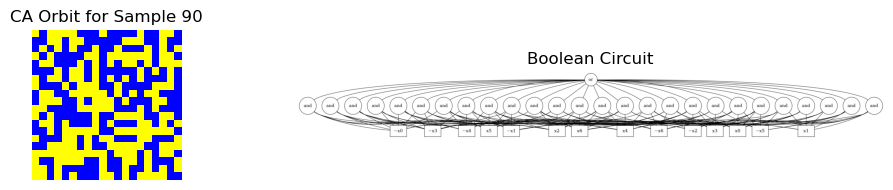

In [ ]:
## import matplotlib.pyplot as plt
import numpy as np
import graphviz
from PIL import Image
from pyeda.inter import expr
import os

def visualize_ca_and_circuit_side_by_side(dataset, sample_index, r):
    # Part 1: Visualize the CA orbit
    # Define the colormap: yellow for 1, blue for 0
    cmap = plt.cm.colors.ListedColormap(['blue', 'yellow'])
    bounds = [0, 0.5, 1]
    norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)

    # Get the specific sample from the dataset
    sample = dataset[sample_index]

    # Extract the rule for this sample from the dataset
    rule_bin = sample['rule']

    # Extract CA states and convert them to numerical arrays
    ca_states = [np.array([int(bit) for bit in sample[f't={t}']]) for t in range(len(sample) - 1)]

    # Plot the CA orbit
    fig, axs = plt.subplots(1, 2, figsize=(11, 2))
    axs[0].imshow(ca_states, cmap=cmap, norm=norm)
    axs[0].set_title(f"CA Orbit for Sample {sample_index}")
    axs[0].axis('off')

    # Part 2: Visualize the Boolean Circuit
    # Convert the binary rule into a Boolean expression using PyEDA

    # Combine terms into an OR expression
    boolean_expr = rebuild_circuit_reversed_bits(rule_bin, r)

    # Use PyEDA to create an expression object
    expr_obj = expr(boolean_expr)

    # Convert to a logic circuit graph and output the .dot file
    dot = expr_obj.to_dot()

    # Clean the dot string (remove any unexpected characters like ',')
    cleaned_dot = dot.replace("', '", "").strip()

    # Write the cleaned .dot file for rendering
    with open("boolean_circuit.dot", "w") as f:
        f.write(cleaned_dot)

    # Render the circuit using Graphviz and save as PNG
    graph = graphviz.Source(cleaned_dot)
    graph.render("boolean_circuit", format="png")

    # Open the saved circuit PNG file and display it
    img = Image.open("boolean_circuit.png")

    # Display the Boolean Circuit in the second subplot
    axs[1].imshow(img)
    axs[1].set_title("Boolean Circuit")
    axs[1].axis('off')

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# Example usage
sample_index = 90     # Example sample index from the dataset
r = 3

# Extract the rule (truth table) from the dataset
sample = CA_data[sample_index]
rule_bin = sample['rule']

# Rebuild the Boolean circuit from the truth table with reversed bit order
circuit = rebuild_circuit_reversed_bits(rule_bin, r)

# Calculate the complexity of the simplified circuit
circuit_str = str(circuit)
#x = 'Or(And(~x0, x1, ~x2, ~x3), And(x0, x2, ~x4), And(x0, ~x1, x2), And(x0, ~x1, x3, ~x4), And(~x1, x2, ~x3, x4), And(~x0, x1, x4), And(x0, ~x2, ~x3, x4), And(~x1, x2, x3, ~x4))'
x = circuit_str
parser = BooleanExpressionParser(x)
gate_count, depth = parser.parse()
print(f"String representation of circuit: {x}")
# Output the complexity metrics
print("Simplified Boolean Circuit Complexity:")
print(f"Gate Count: {gate_count}")
print(f"Circuit Depth: {depth}")

visualize_ca_and_circuit_side_by_side(CA_data, sample_index, r)

In [ ]:
#### sample_index = 42     # Example sample index from the dataset
r = 3
visualize_ca_and_circuit_side_by_side(CA_data, sample_index, r)

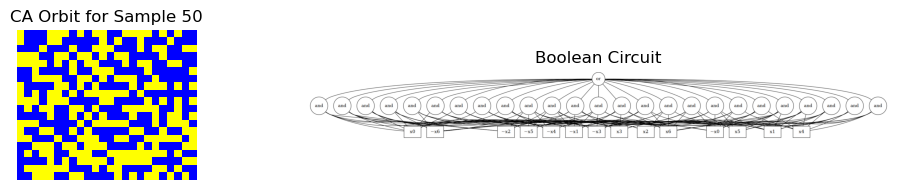

In [ ]:
sample_index = 50     # Example sample index from the dataset
r = 3
visualize_ca_and_circuit_side_by_side(CA_data, sample_index, r)